In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import codecs
import re
import os
import pickle
import seaborn as sn
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,TfidfTransformer
from sklearn import preprocessing
from gensim.models.word2vec import Word2Vec
from gensim import models

def keyword_count(keywords,Data):
    output = []
    for data in Data:
        output.append([data.count(keyword) for keyword in keywords])    
    return output

def most_similar(w2v_model, words, topn=10):
    similar_df = pd.DataFrame()
    for word in words:
        try:
            similar_words = pd.DataFrame(w2v_model.wv.most_similar(word, topn=topn), columns=[word, 'cos'])
            similar_df = pd.concat([similar_df, similar_words], axis=1)
        except:
            print(word, "not found in Word2Vec model!")
    return similar_df


# Read Data from 10-K Data Handling

In [2]:
Company = []
#Company = ['GOOGL','AMZN','JPM']

with open('./Nomura_Report/Available.pkl', 'rb') as f:
    Company = pickle.load(f)

Data = []
for company in Company:
    path    = './10-K Data/sec_edgar_filings/'+company
    dic     = {}

    for dirPath, dirNames, fileNames in os.walk(path):
        for f in fileNames:
            if bool(re.search(r"pkl$",f)):
                year = int(re.findall(r"\d+",f)[0])
                dic[year] = os.path.join(dirPath, f)

    for year in dic:
        try:
            with open(dic[year], 'rb') as f:
                data = pickle.load(f)
                if len(data) != 0: 
                    Data.append([year,company,data])
                else:
                    print('No Data at '+company+' in',year)
        except:
            print('No Data at '+company+' at',year)
    

In [3]:
df_content = pd.DataFrame(Data,columns=['Year', 'Company', 'Content'])
print('Total Nomura Report Company :',len(Company))
print('=====================================')
for year in range(2013,2020):
    print('Total Available Data at '+str(year)+' are ',len(df_content[df_content['Year'] == year]))

Total Nomura Report Company : 67
Total Available Data at 2013 are  4
Total Available Data at 2014 are  12
Total Available Data at 2015 are  33
Total Available Data at 2016 are  33
Total Available Data at 2017 are  34
Total Available Data at 2018 are  33
Total Available Data at 2019 are  25


In [4]:
df_content.head()

,Year,Company,Content
0,2014,MU,"[corporate, information, micron, delaware, cor..."
1,2015,MU,"[overview, micron, technology, inc., including..."
2,2016,MU,"[following, discussion, contains, trend, infor..."
3,2017,MU,"[overview, manufacture, product, worldwide, wh..."
4,2018,MU,"[overview, manufacture, product, wholly-owned,..."


# For Specific Year

In [15]:
YEAR = 2018
keywords_num = 20
# Find Keyword
fdist_content = nltk.FreqDist(sum(df_content[df_content['Year'] == YEAR]['Content'],[]))
df_fdist_content  = pd.DataFrame.from_dict(fdist_content, orient='index')
df_fdist_content.columns = ['Counts']
df_fdist_content  = df_fdist_content.sort_values(by=['Counts'], ascending=False)
keywords = list(df_fdist_content[:keywords_num].index)
keywords_count = list(df_fdist_content[:keywords_num]['Counts'])

In [16]:
filtered_content = list(df_content[df_content['Year'] == YEAR]['Content'])
count = keyword_count(keywords,filtered_content)
table = pd.DataFrame(count,columns = keywords, index = list(df_content[df_content['Year'] == YEAR]['Company']))
table.head()

,business,operation,service,financial,cost,million,cash,including,company,market,product,customer,revenue,tax,operating,change,year,future,asset,certain
MU,105,116,26,95,98,20,54,63,10,61,270,106,33,60,29,30,22,46,24,63
ARMK,141,78,119,88,86,89,52,59,28,24,34,16,43,52,32,33,33,40,37,68
ERI,112,137,54,75,71,138,89,90,57,77,3,64,92,109,87,63,139,84,87,93
WDC,1,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0
FDC,1,1,0,1,0,0,0,0,0,3,0,0,0,1,0,0,0,0,0,0


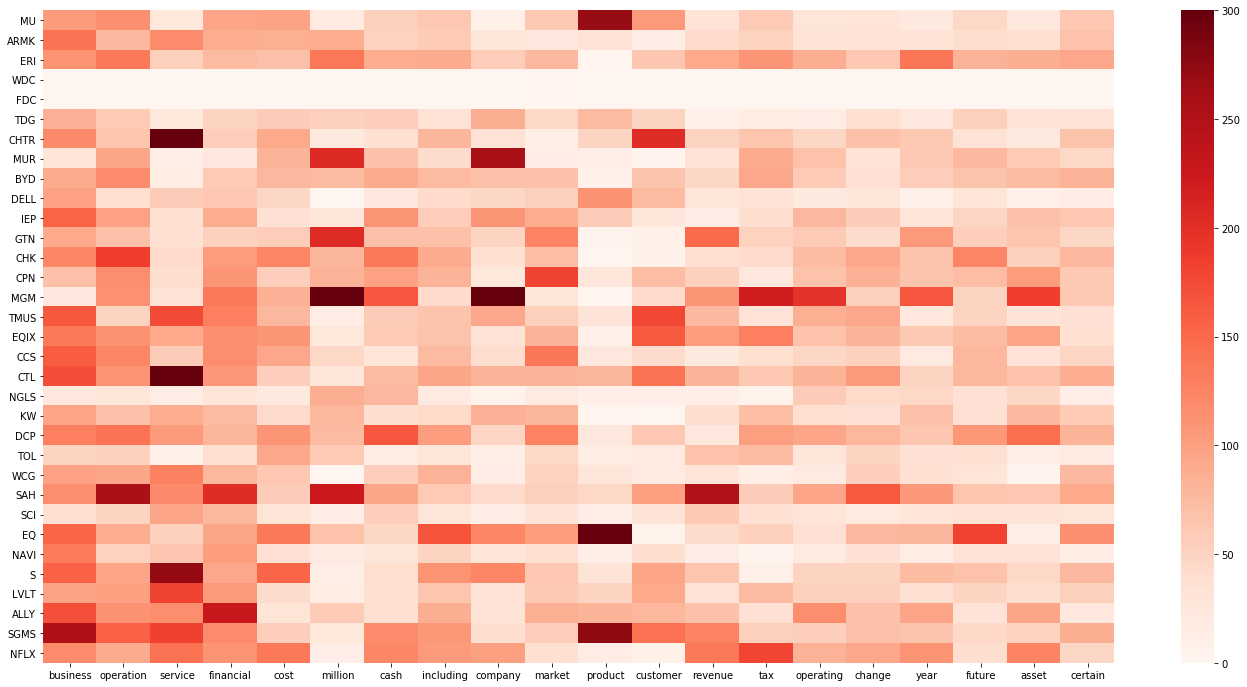

In [17]:
plt.figure(figsize=(24,12))
sn.heatmap(table,vmin = 0,vmax = 300,cmap='Reds')
plt.show()

In [18]:
CoorMatrix = table.transpose().dot(table)
CoorMatrix

,business,operation,service,financial,cost,million,cash,including,company,market,product,customer,revenue,tax,operating,change,year,future,asset,certain
business,475715,372511,411859,361340,272494,201045,250470,278046,216248,249996,298016,264147,234089,206005,214412,232077,207187,220955,203181,217907
operation,372511,371030,309358,323729,240953,258779,248804,233816,219406,220853,210444,209750,233373,207707,210577,216672,208238,203504,203172,200921
service,411859,309358,519427,312776,240809,146363,204661,244733,192431,187615,200001,288370,219026,182899,189765,213375,184549,173652,171509,194264
financial,361340,323729,312776,329122,216047,220496,215636,217082,205915,204337,204652,208962,217235,188585,202983,201296,191216,176002,190261,172873
cost,272494,240953,240809,216047,208515,165425,172738,181849,180376,157238,180895,150853,151352,162537,144944,148376,148652,157830,142884,144766
million,201045,258779,146363,220496,165425,352224,202721,144106,280048,146134,97950,106087,195523,195849,193529,146229,197164,146218,185809,139381
cash,250470,248804,204661,215636,172738,202721,205245,163827,191849,154140,128869,135704,157563,168664,165116,148752,157447,144234,168887,140164
including,278046,233816,244733,217082,181849,144106,163827,182731,152304,160822,206705,148725,145723,140152,137790,145526,142616,151276,133958,143402
company,216248,219406,192431,205915,180376,280048,191849,152304,337144,126509,141943,119273,150373,202027,186700,130124,175278,143246,178888,134115
market,249996,220853,187615,204337,157238,146134,154140,160822,126509,182083,152237,130295,130641,122452,130493,134271,127953,141378,134644,127108


In [19]:
CoorMatrix_normalize = pd.DataFrame(preprocessing.normalize(CoorMatrix),columns = keywords, index = CoorMatrix.index)
CoorMatrix_normalize

,business,operation,service,financial,cost,million,cash,including,company,market,product,customer,revenue,tax,operating,change,year,future,asset,certain
business,0.380218,0.297732,0.329181,0.288803,0.217792,0.160686,0.200190,0.222230,0.172838,0.199811,0.238191,0.211121,0.187097,0.164651,0.171370,0.185489,0.165595,0.176600,0.162394,0.174163
operation,0.331985,0.330665,0.275702,0.288510,0.214739,0.230626,0.221736,0.208379,0.195536,0.196826,0.187549,0.186931,0.207984,0.185110,0.187668,0.193100,0.185583,0.181365,0.181069,0.179063
service,0.360687,0.270922,0.454891,0.273915,0.210890,0.128178,0.179233,0.214326,0.168522,0.164305,0.175152,0.252541,0.191813,0.160175,0.166188,0.186864,0.161620,0.152077,0.150200,0.170128
financial,0.344800,0.308911,0.298459,0.314057,0.206158,0.210403,0.205766,0.207145,0.196490,0.194984,0.195284,0.199397,0.207291,0.179953,0.193692,0.192082,0.182463,0.167946,0.181552,0.164960
cost,0.334355,0.295654,0.295477,0.265094,0.255852,0.202980,0.211953,0.223132,0.221325,0.192934,0.221962,0.185100,0.185712,0.199436,0.177849,0.182060,0.182399,0.193660,0.175321,0.177631
million,0.230467,0.296650,0.167782,0.252764,0.189634,0.403770,0.232388,0.165195,0.321031,0.167520,0.112284,0.121612,0.224137,0.224510,0.221851,0.167629,0.226018,0.167616,0.213001,0.159779
cash,0.311887,0.309812,0.254845,0.268511,0.215095,0.252430,0.255572,0.203999,0.238892,0.191936,0.160469,0.168980,0.196199,0.210022,0.205604,0.185227,0.196054,0.179601,0.210299,0.174533
including,0.350376,0.294640,0.308397,0.273553,0.229155,0.181593,0.206444,0.230266,0.191924,0.202658,0.260477,0.187414,0.183631,0.176611,0.173634,0.183383,0.179716,0.190629,0.168805,0.180706
company,0.253833,0.257539,0.225876,0.241704,0.211726,0.328721,0.225193,0.178775,0.395741,0.148497,0.166613,0.140003,0.176508,0.237140,0.219149,0.152740,0.205742,0.168143,0.209979,0.157425
market,0.349720,0.308952,0.262455,0.285848,0.219961,0.204427,0.215627,0.224974,0.176974,0.254717,0.212965,0.182270,0.182754,0.171299,0.182547,0.187832,0.178994,0.197774,0.188354,0.177812


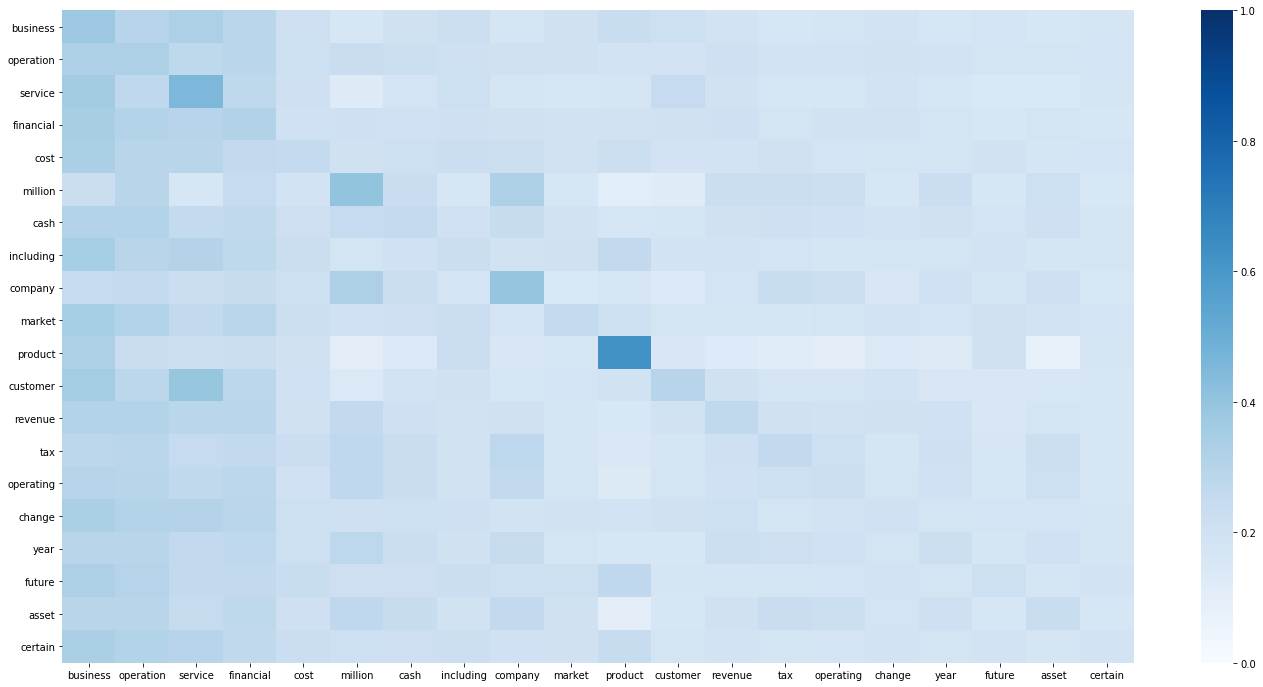

In [20]:
plt.figure(figsize=(24,12))
sn.heatmap(CoorMatrix_normalize,vmin = 0,vmax = 1,cmap='Blues')
plt.show()

In [21]:
model = Word2Vec(df_content[df_content['Year'] == YEAR]['Content'],size=250, iter=10, sg=0, min_count=3)

In [22]:
most_similar(model, keywords, topn=10)

,business,cos,operation,cos,service,cos,financial,cos,cost,cos,...,change,cos,year,cos,future,cos,asset,cos,certain,cos
0,prospect,0.764248,business,0.709534,wireless,0.696846,prospect,0.713226,delay,0.732256,...,favorable/,0.756471,ago,0.870690,current,0.735526,intangible,0.791248,various,0.671744
1,reputation,0.724616,operating,0.685548,client,0.682543,discussion,0.699718,saving,0.729068,...,outlook,0.718595,ended,0.839841,timing,0.730709,value,0.767632,creditor,0.667657
2,operation,0.709534,prospect,0.643978,customer,0.681668,forward-looking,0.662199,expense,0.721115,...,climate,0.717509,last,0.823927,unfavorable,0.723700,long-lived,0.747846,contractual,0.664666
3,strength,0.705791,harmed,0.613768,provider,0.679380,liquidity,0.647197,timing,0.715228,...,dramatically,0.700047,december,0.803523,materially,0.699411,carrying,0.744109,transfer,0.660743
4,managing,0.692269,financial,0.564526,wireline,0.678010,analysis,0.646759,incurred,0.705604,...,oci,0.687866,fiscal,0.793839,actual,0.674641,goodwill,0.739756,licensing,0.658199
5,key,0.687541,adverse,0.562881,voice,0.658359,prediction,0.645875,reduction,0.703517,...,applicability,0.673760,even-numbered,0.789092,could,0.672108,write-down,0.736721,guarantee,0.650863
6,harmed,0.672832,hole,0.559839,internet,0.656976,forward‑looking,0.620908,unexpected,0.700607,...,economy,0.667385,dispensed,0.783580,nature,0.670004,tangible,0.733612,limitation,0.649649
7,harm,0.658885,continuing,0.553342,offered,0.653455,caution,0.617538,resulting,0.700269,...,uncertain,0.665308,versus,0.756850,extent,0.665429,excess,0.730186,instance,0.646999
8,ordinary,0.658541,interrupt,0.519223,managed,0.648882,harmed,0.599384,unforeseen,0.698792,...,stagnation,0.659590,ending,0.754688,supportable,0.663959,nonqualifying,0.729137,chooses,0.642462
9,strategy,0.657047,harvey,0.517729,handset,0.644665,macro-economic,0.591765,absorb,0.698053,...,trend,0.651842,calendar,0.742946,past,0.655695,residual,0.721322,customary,0.641756
